<div style="background-color:rgba(50,50,50, 1); text-align:center; vertical-align: middle; padding:40px 0;">
 
 <font color='white'>
 <h1> TV Viewership Prediction Exercise </h1>
 </font>
</div>


## Dataset
---

The data set for the exercise is a sample of TV Viewership data from LG subscribers across a month. The dataset is a TSV file with following format:


| Column | Description  | Details |
| ------ | -----------  | ------- |
| household_id | Unique Household Identifier |  |  
|session_start | Start time for the viewing session| YYYY-MM- DD HH:MM:SS|
|session_end |End time for the viewing session |YYYY-MM- DD HH:MM:SS|
|channel_name |Channel Name||  
|title |Programme Title||  
|original_broadcast_start|Start time for the original broadcast||  
|original_broadcast_end| End time of the original broadcast||  
|session_type |Type of the Viewing session |Live, Timeshift, OD etc|
|session_sub_type |Session sub type |Buffer, Series Link, TVoD etc|
|genre |Genre of the programme| | 
|sub_genre |Sub Genre of the programme played||  
|playback_speed |Speed at which the session was watched at |1000 = Normal Speed, 2000 = 2x|
|episode_title |Episode Title || 
|series_title |Series Title||  
|gender |Gender of the bill payer||  
|dob |Date of Birth of the bill payer|Default value (1900-01- 01) or missing in some cases.|

## Objective
---
The objective of the exercise is to create a model to predict and assign one of the following age-
bands to each of the individual households present in the dataset.

<left>

| Target Classes |
| -------------- |
| 1. <25 |
| 2. 25-35|
|3. 35-45|
|4. 45-55|
|5. 55-65|
|6. 66|


Present the model back to the LG team, clearly explaining the various steps undertaken to construct
the model including data exploration, feature extraction, method choices / evaluation etc. Include
any artefacts including code, notebooks etc to further the understanding of the approach.

<div style="background-color:rgba(230,230,230, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h2> TABLE OF CONTENTS </h2>
 <p>    <a href='#section1'>Section 1 - Data Exploration'</a> </p> 
 <p>    <a href='#section1'>Section 2 - Data Cleaning'</a> </p>
 <p>    <a href='#section1'>Section 3 - Feature Generation'</a> </p>
 <p>    <a href='#section1'>Section 4 - Calculating Target Variable - Age Group'</a> </p>
 <p>    <a href='#section1'>Section 5 - Categorical Data Encoding'</a> </p>
 <p>    <a href='#section1'>Section 6 - Feature Selection'</a> </p>
 <p>    <a href='#section1'>Section 7 - Splitting Traing and Test Data ( applied on full data )'</a> </p>
 <p>    <a href='#section1'>Section 8 - Model Creation and Accuracy Assessment ( applied on full data )'</a> </p>
 <p>    <a href='#section1'>Section 9 - Splitting Traing and Test Data ( applied on selected features only)'</a> </p>
 <p>    <a href='#section1'>Section 10 - Model Creation and Accuracy Assessment ( applied on selected features only)'</a> </p>

 </font>
</div>








In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from datetime import date
from datetime import datetime, timedelta

import csv

from seaborn import set_style
set_style('darkgrid')
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold




<a id='section1'></a>

# SECTION 1. Data Exploration

- Column headings are in order; all names are small caps, no spaces, have underscores as separators. However the data have invalid values (defaluts), invalid data types and NaNs. 

In [2]:
# A quick exploration was performed on data before deciding on the parameters for read_csv. 
# converting appropriate columns to datetime type and infering datetime format caused issues in the feature selection stage.
# Hence it was decided to leave them as 'object' and convert on the fly; also because they were not gonna get used as timestamps
# /t was used as a separator because the description of the data suggested it was a TSV.


file_path = "./viewership_extract.csv.gz"

parse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" )

viewings = pd.read_csv(file_path, sep='\t', compression = "gzip", )

In [3]:
viewings.columns

Index(['household_id', 'session_start', 'session_end', 'channel_name', 'title',
       'original_broadcast_start', 'original_broadcast_end', 'session_type',
       'session_sub_type', 'genre', 'sub_genre', 'playback_speed',
       'episode_title', 'series_title', 'gender', 'dob'],
      dtype='object')

In [4]:
viewings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3863142 entries, 0 to 3863141
Data columns (total 16 columns):
household_id                int64
session_start               object
session_end                 object
channel_name                object
title                       object
original_broadcast_start    object
original_broadcast_end      object
session_type                object
session_sub_type            object
genre                       object
sub_genre                   object
playback_speed              float64
episode_title               object
series_title                object
gender                      object
dob                         object
dtypes: float64(1), int64(1), object(14)
memory usage: 471.6+ MB


In [5]:
viewings.head()

,household_id,session_start,session_end,channel_name,title,original_broadcast_start,original_broadcast_end,session_type,session_sub_type,genre,sub_genre,playback_speed,episode_title,series_title,gender,dob
0,432215006,2016-04-09 08:36:52,2016-04-09 08:51:52,Nick Junior,Paw Patrol,2016-04-08 10:30:00,2016-04-08 10:45:00,TIMESHIFT,SERIES LINK BOOKING,Kids/Youth,For ages 6-14,1000.0,Pups and the Mischievous Kittens,NaN,Please Specify,1900-01-01
1,432215006,2016-04-27 10:03:48,2016-04-27 10:03:48,Nick Junior,Paw Patrol,2016-04-27 10:00:00,2016-04-27 10:15:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,Pups Save a Sniffle,NaN,Please Specify,1900-01-01
2,432215006,2016-04-27 17:03:48,2016-04-27 17:03:48,Nick Junior,Paw Patrol,2016-04-27 17:00:00,2016-04-27 17:15:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,Pups Save a Sniffle,NaN,Please Specify,1900-01-01
3,432215006,2016-04-18 09:02:46,2016-04-18 09:17:46,Nick Junior,Paw Patrol,2016-04-18 08:45:00,2016-04-18 09:00:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,NaN,NaN,Please Specify,1900-01-01
4,432215006,2016-04-22 17:28:45,2016-04-22 17:28:45,Nick Junior,Paw Patrol,2016-04-22 17:15:00,2016-04-22 17:30:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,NaN,NaN,Please Specify,1900-01-01


In [6]:
viewings.tail()

,household_id,session_start,session_end,channel_name,title,original_broadcast_start,original_broadcast_end,session_type,session_sub_type,genre,sub_genre,playback_speed,episode_title,series_title,gender,dob
3863137,432229388,2016-04-12 22:30:00,2016-04-12 23:00:00,Nickelodeon HD,iCarly,2016-04-12 22:30:00,2016-04-12 23:00:00,LIVE,LIVE,Kids/Youth,For ages 6-14,1000.0,iDon't Want to Fight,NaN,Female,1900-01-01
3863138,432229388,2016-04-07 20:00:00,2016-04-07 20:30:00,Nickelodeon HD,Bella and the Bulldogs,2016-04-07 20:00:00,2016-04-07 20:30:00,LIVE,LIVE,Kids/Youth,For ages 6-14,1000.0,No Girls Allowed,Bella and the Bulldogs - Series 1,Female,1900-01-01
3863139,432229388,2016-04-26 18:00:23,2016-04-26 18:30:23,Disney Channel HD,Best Friends Whenever,2016-04-26 18:00:00,2016-04-26 18:30:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,Shake Your Booty,NaN,Female,1900-01-01
3863140,432229388,2016-04-26 17:23:23,2016-04-26 17:23:41,Disney Channel HD,Mako Mermaids,2016-04-26 17:23:18,2016-04-26 17:23:18,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,0.0,Decision Time,NaN,Female,1900-01-01
3863141,432229388,2016-04-14 18:00:00,2016-04-14 18:11:28,Nickelodeon HD,Make it Pop,2016-04-14 18:00:00,2016-04-14 18:30:00,LIVE,LIVE,Kids/Youth,For ages 6-14,1000.0,Spring Fling,NaN,Female,1900-01-01


<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - Dataframe shape  </h3>
 <p> 16 Columns and 3.86m Records  </p>
 </font>
</div>

In [7]:
viewings.shape

(3863142, 16)

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - Data Type </h3>
 <p> As can be seen below, only two columns are numerical, while none of the date/time containing columns were originally of appropriate data type. However after inspection they were forced to be read as datetime format </p>
 </font>
</div>


In [8]:
viewings.describe()

,household_id,playback_speed
count,3.863142e+06,3.862360e+06
mean,4.322219e+08,2.744130e+03
std,4.324509e+03,7.575827e+03
min,4.322145e+08,-3.000000e+04
25%,4.322181e+08,1.000000e+03
50%,4.322218e+08,1.000000e+03
75%,4.322257e+08,1.000000e+03
max,4.322295e+08,3.000000e+04


<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation  </h3>
 <p> There are 6 columns with NaNs; episode_title and series_title with the largest quantities. These will need to be resolved. Some classifiers such as decision trees are capable of handling NaNs, while others produce unexpected results.   </p>
 </font>
</div>


In [9]:
viewings.isnull().sum()


household_id                      0
session_start                     0
session_end                       0
channel_name                      0
title                             5
original_broadcast_start      12181
original_broadcast_end        12181
session_type                      0
session_sub_type                  0
genre                             0
sub_genre                         0
playback_speed                  782
episode_title               2805111
series_title                1771372
gender                            0
dob                               0
dtype: int64

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Broadcast start and end time' column  </h3>
 <p> apart from NaNs/NaTs, the column seems to be OK. Quite peculiar that the number os NaNs in both columns are exactly the same. There are methods that can impute time based on the patterns modelled in the data, however in this case the values will either be left as NaNs or the rows with NaNs will be removed</b> </p>
 </font>
</div>


In [10]:
pd.Categorical(viewings.original_broadcast_start).describe().sort_values(by='counts')

,counts,freqs
categories,,
2000-12-31 00:00:16,1,2.588567e-07
2016-04-16 04:20:06,1,2.588567e-07
2016-04-16 04:20:08,1,2.588567e-07
2016-04-16 04:20:11,1,2.588567e-07
2016-04-16 04:20:26,1,2.588567e-07
2016-04-16 04:20:41,1,2.588567e-07
2016-04-16 04:20:46,1,2.588567e-07
2016-04-16 04:20:54,1,2.588567e-07
2016-04-16 04:21:44,1,2.588567e-07


In [11]:
pd.Categorical(viewings.original_broadcast_start).describe().sort_index()

,counts,freqs
categories,,
NaN,12181,3.153133e-03
2000-12-31 00:00:16,1,2.588567e-07
2000-12-31 00:00:17,2,5.177133e-07
2000-12-31 00:00:21,2,5.177133e-07
2000-12-31 00:00:22,6,1.553140e-06
2000-12-31 00:00:23,2,5.177133e-07
2000-12-31 00:00:25,1,2.588567e-07
2000-12-31 00:00:28,2,5.177133e-07
2000-12-31 00:00:31,3,7.765700e-07


In [12]:
pd.Categorical(viewings.original_broadcast_end).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
2000-12-30 23:59:51,1,2.588567e-07
2016-04-16 02:06:45,1,2.588567e-07
2016-04-16 02:06:50,1,2.588567e-07
2016-04-16 02:06:55,1,2.588567e-07
2016-04-16 02:06:59,1,2.588567e-07
2016-04-16 02:07:00,1,2.588567e-07
2016-04-16 02:07:02,1,2.588567e-07
2016-04-16 02:07:09,1,2.588567e-07
2016-04-16 02:07:19,1,2.588567e-07


In [13]:
pd.Categorical(viewings.original_broadcast_end).describe().sort_index()

,counts,freqs
categories,,
NaN,12181,3.153133e-03
2000-12-30 23:59:51,1,2.588567e-07
2000-12-31 00:00:22,2,5.177133e-07
2000-12-31 00:00:28,3,7.765700e-07
2000-12-31 00:00:34,3,7.765700e-07
2000-12-31 00:00:35,1,2.588567e-07
2000-12-31 00:00:39,1,2.588567e-07
2000-12-31 00:00:42,1,2.588567e-07
2000-12-31 00:00:43,3,7.765700e-07


<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Session Type' column  </h3>
 <p> No issues with this column</b> </p>
 </font>
</div>


In [14]:
pd.Categorical(viewings.session_type).describe().sort_values(by='counts')

,counts,freqs
categories,,
REPLAY,3308,0.000856
VOD,14373,0.003721
TIMESHIFT,1552826,0.401959
LIVE,2292635,0.593464


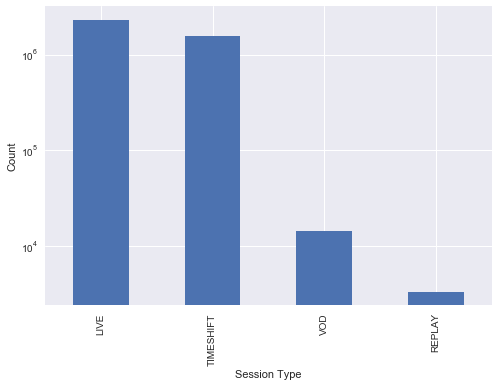

In [15]:
viewings['session_type'].value_counts().plot(kind="bar", logy=True);
plt.xlabel('Session Type')
plt.ylabel('Count')
plt.show();

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Sub Genre' column  </h3>
 <p> The 'sub_genre' column seem to have no anomolous content, <b>apart from 'undefined' and 'unclassified' values</b>. These values will be changed to one or the other for simplicity. This will create a cell value with a dominant frequency in the column; but that shouldnt cause much issues. </p>
 </font>
</div>


In [16]:
pd.Categorical(viewings.sub_genre).describe().sort_values(by='counts')

,counts,freqs
categories,,
Game Show,9,0.000002
For ages 10-16,12,0.000003
Ballet,48,0.000012
Water Sport,81,0.000021
Special Event,101,0.000026
Handicraft,115,0.000030
Performing Arts,117,0.000030
Languages,128,0.000033
Musical/Opera,189,0.000049


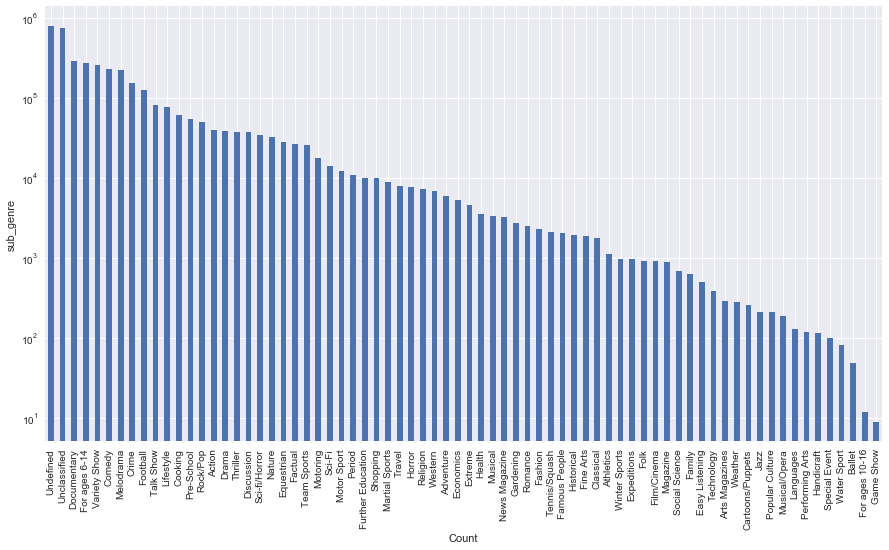

In [17]:
viewings['sub_genre'].value_counts().plot(kind="bar", figsize=(15,8), logy=True);
plt.xlabel('Count')
plt.ylabel('sub_genre')
plt.show();

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Playback Speed' column  </h3>
 <p> Playback Speed column has negative values, which might indicate reverse playback, but due to the lack of subject knowledge that is all I can assume. There are 782 NaNs as well and 154K ZERO values. Slightly unsure about zero speed, as the specifications suggest normal playback speed is 1000.</b> </p>
 </font>
</div>


In [18]:
viewings.query('playback_speed == 1000')

,household_id,session_start,session_end,channel_name,title,original_broadcast_start,original_broadcast_end,session_type,session_sub_type,genre,sub_genre,playback_speed,episode_title,series_title,gender,dob
0,432215006,2016-04-09 08:36:52,2016-04-09 08:51:52,Nick Junior,Paw Patrol,2016-04-08 10:30:00,2016-04-08 10:45:00,TIMESHIFT,SERIES LINK BOOKING,Kids/Youth,For ages 6-14,1000.0,Pups and the Mischievous Kittens,NaN,Please Specify,1900-01-01
1,432215006,2016-04-27 10:03:48,2016-04-27 10:03:48,Nick Junior,Paw Patrol,2016-04-27 10:00:00,2016-04-27 10:15:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,Pups Save a Sniffle,NaN,Please Specify,1900-01-01
2,432215006,2016-04-27 17:03:48,2016-04-27 17:03:48,Nick Junior,Paw Patrol,2016-04-27 17:00:00,2016-04-27 17:15:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,Pups Save a Sniffle,NaN,Please Specify,1900-01-01
3,432215006,2016-04-18 09:02:46,2016-04-18 09:17:46,Nick Junior,Paw Patrol,2016-04-18 08:45:00,2016-04-18 09:00:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,NaN,NaN,Please Specify,1900-01-01
4,432215006,2016-04-22 17:28:45,2016-04-22 17:28:45,Nick Junior,Paw Patrol,2016-04-22 17:15:00,2016-04-22 17:30:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,NaN,NaN,Please Specify,1900-01-01
5,432215006,2016-04-13 18:39:37,2016-04-13 18:39:37,Nick Junior,Peppa Pig,2016-04-13 18:30:00,2016-04-13 18:35:00,TIMESHIFT,BUFFER,Kids/Youth,For ages 6-14,1000.0,The Tree House,NaN,Please Specify,1900-01-01
6,432215006,2016-04-23 18:15:00,2016-04-23 18:30:00,Nick Junior,Ben and Holly's Little Kingdom,2016-04-23 18:15:00,2016-04-23 18:30:00,LIVE,LIVE,Kids/Youth,For ages 6-14,1000.0,Daisy and Poppy Go Bananas,Ben and Holly's Little Kingdom - Series 2,Please Specify,1900-01-01
7,432215006,2016-04-01 22:49:08,2016-04-01 23:01:42,Surf,Surf,2016-04-01 22:49:08,2016-04-01 23:01:42,LIVE,LIVE,Unclassified,Unclassified,1000.0,NaN,NaN,Please Specify,1900-01-01
8,432215006,2016-04-01 22:47:19,2016-04-01 22:48:55,Surf,Surf,2016-04-01 22:47:19,2016-04-01 22:48:55,LIVE,LIVE,Unclassified,Unclassified,1000.0,NaN,NaN,Please Specify,1900-01-01
9,432215006,2016-04-08 22:14:45,2016-04-08 22:14:47,Surf,Surf,2016-04-08 22:14:45,2016-04-08 22:14:47,LIVE,LIVE,Unclassified,Unclassified,1000.0,NaN,NaN,Please Specify,1900-01-01


In [19]:
pd.Categorical(viewings.playback_speed).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
NaN,782,0.000202
500.0,883,0.000229
-30000.0,18187,0.004708
2000.0,22957,0.005943
-12000.0,23845,0.006172
-6000.0,26654,0.006900
-2000.0,28536,0.007387
6000.0,47970,0.012417
12000.0,83318,0.021567


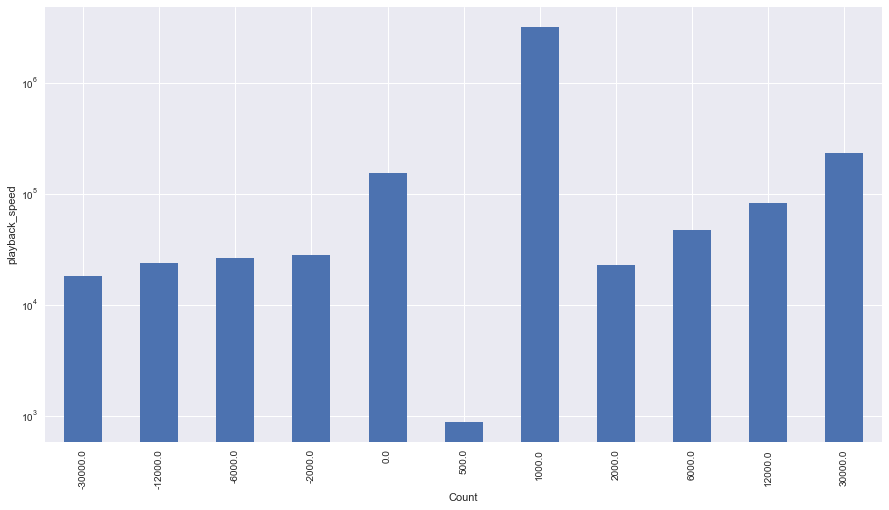

In [20]:
viewings['playback_speed'].value_counts().sort_index().plot(kind="bar", figsize=(15,8), logy=True);
plt.xlabel('Count')
plt.ylabel('playback_speed')
plt.show();

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Series Title' column  </h3>
 <p> This column has a high number of NaN values in the dataset, and some values with # and other unknown characters. For the sake of simplicity these will be left as they are; ideally these will be investigated and resolved.</b> </p>
 </font>
</div>


In [21]:
viewings.series_title.value_counts().sort_index()

#Digitalview                                            30
#Version Fran��aise                                      5
'Allo 'Allo! - Series 3                                 20
'Allo 'Allo! - Series 4                                 11
100 Things to Do Before High School                     10
100 Things to Do Before High School - Series 1         292
100%                                                    66
1000 Heartbeats - Series 2                             118
1000 Ways to Die - Series 5                            126
101 Things You Don't Need a Builder For - Series 1       5
12 Monkeys - Series 2                                   27
13 h 15, le samedi                                       1
15 Storeys High - Series 1                              24
15 Storeys High - Series 2                              83
16 Kids and Counting                                  1188
16 and Pregnant - Series 1                              13
16 and Pregnant - Series 2                              

In [22]:
pd.Categorical(viewings.series_title).describe().sort_values(by='counts')

,counts,freqs
categories,,
"Exp��dition, passage du Nord-Ouest",1,2.588567e-07
Echo-logis,1,2.588567e-07
Afrique presse,1,2.588567e-07
Private View,1,2.588567e-07
Elite Ice Hockey League - 2015/16 Repeats,1,2.588567e-07
Emergency Vets - Series 5,1,2.588567e-07
Emilie,1,2.588567e-07
Baskup - Tony Parker,1,2.588567e-07
Aglow National Conference,1,2.588567e-07


<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Episode Title' column  </h3>
 <p> This column has the most NaN values in the dataset, and some values with # and additional space. For the sake of simplicity these will be left as they are as there are only few in numbers; ideally these will be investigated and resolved.</b> </p>
 </font>
</div>


In [23]:
viewings.episode_title.value_counts().sort_index()

 Ferrari Fix Part 2/1917 REO           5
#6                                    34
#BlooperEpisode                       73
#BlueDogSoda                         102
#DroneBabyDrone                       45
#FindKaylaWeber                       44
#FirstClassProblems                  109
#FresnoGirl                          102
#GettinWiggy                          22
#GoatPoop                            199
#KnockOut                             82
#StuckInABox                          69
#SuperPsycho                         129
#WeStealARockStar                    127
'07 Maybach                           27
'32 Hi-Boy Roadster, Part 1            4
'32 Hi-Boy Roadster, Part 2            5
'32 Hi-Boy Roadster, Part 3           10
'42 Woodie, Part 3                     2
'48 Chevy Fleetmaster                 63
'57 Corvette, Part 1                 290
'57 Corvette, Part 2                 252
'57 Heaven!                            8
'58 Chevy and Nomad Wagon             12
'65 Mustang, Par

In [24]:
pd.Categorical(viewings.episode_title).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
Olivia Acts Out,1,2.588567e-07
Temperance: Getting in Shape,1,2.588567e-07
Clarity (HD),1,2.588567e-07
Eggman the Auteur,1,2.588567e-07
Palm Sunday of the Lord's Passion,1,2.588567e-07
Croxteth Hall,1,2.588567e-07
Hostage Crisis,1,2.588567e-07
Ep. 168 A Fairy Animal For Tecna,1,2.588567e-07
Broken Places (HD),1,2.588567e-07


In [25]:
pd.Categorical(viewings.episode_title).describe().sort_index()

,counts,freqs
categories,,
NaN,2805111,7.261216e-01
Ferrari Fix Part 2/1917 REO,5,1.294283e-06
#6,34,8.801126e-06
#BlooperEpisode,73,1.889654e-05
#BlueDogSoda,102,2.640338e-05
#DroneBabyDrone,45,1.164855e-05
#FindKaylaWeber,44,1.138969e-05
#FirstClassProblems,109,2.821537e-05
#FresnoGirl,102,2.640338e-05


<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Gender' column  </h3>
 <p> A relatively clean data, but two values are anomolous which will need to be merged.</b> </p>
 </font>
</div>


In [26]:
pd.Categorical(viewings.gender).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
To be specified,39837,0.010312
Female,1006154,0.260450
Male,1355064,0.350767
Please Specify,1462087,0.378471


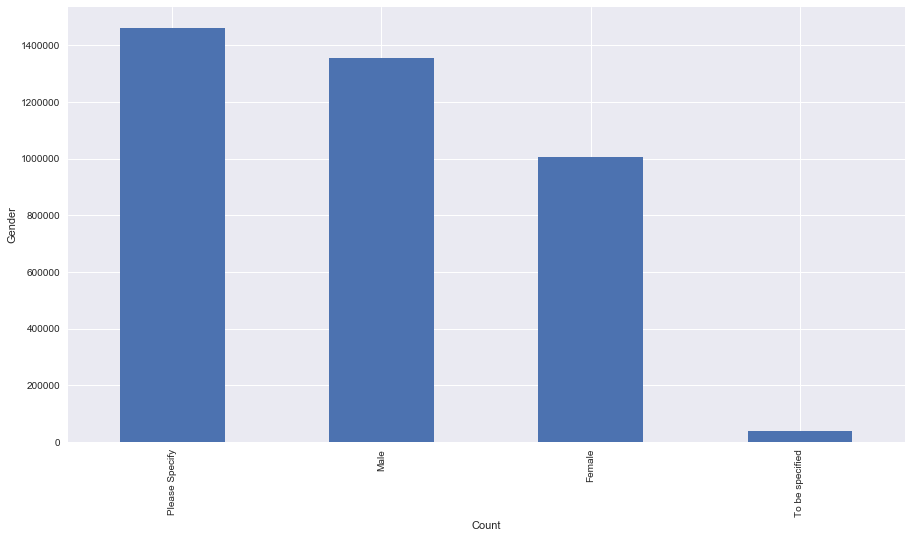

In [27]:
viewings['gender'].value_counts().plot(kind="bar", figsize=(15,8));
plt.xlabel('Count')
plt.ylabel('Gender')
plt.show();

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'DoB' column  </h3>
 <p> An anomolous date of 1900-01-01. This will need to be either removed or set to NaN, as they wont get classified in to the target age groups needed from this column. </p>
 </font>
</div>


In [28]:
pd.Categorical(viewings.dob).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
1946-04-02,1,2.588567e-07
1947-01-09,1,2.588567e-07
1965-11-01,1,2.588567e-07
1986-09-23,1,2.588567e-07
1964-09-14,1,2.588567e-07
1980-10-05,2,5.177133e-07
1983-05-01,3,7.765700e-07
1985-09-28,5,1.294283e-06
1982-06-09,5,1.294283e-06


In [29]:
pd.Categorical(viewings.dob).describe().sort_index()

,counts,freqs
categories,,
1900-01-01,2568362,0.664838
1911-04-09,1007,0.000261
1927-10-27,1355,0.000351
1930-06-02,1962,0.000508
1930-08-09,874,0.000226
1930-12-26,365,0.000094
1931-03-03,2164,0.000560
1932-07-28,328,0.000085
1934-04-29,1072,0.000277


<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'channel_name' column  </h3>
 <p> After close inspection, the 'channel_name' column seem to have no anomolous content, <b>apart from an 'unknown' value</b> </p>
 </font>
</div>


In [30]:
#no null values
viewings.channel_name.isnull().sum()

0

In [31]:
#values seem to be unique
pd.Categorical(viewings.channel_name).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
Zee TV,1,2.588567e-07
BT Sport Extra 4,8,2.070853e-06
BT Sport Extra 5,9,2.329710e-06
TVX,11,2.847423e-06
WRN,14,3.623993e-06
BT Sport Europe,16,4.141706e-06
BT Sport Extra 3,29,7.506843e-06
Sky Select HD,31,8.024556e-06
CCTv,38,9.836553e-06


In [32]:
viewings.loc[viewings.channel_name.str.contains("unk", case=False, regex=True), "channel_name"].describe()

count        9365
unique          1
top       unknown
freq         9365
Name: channel_name, dtype: object

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Title' column  </h3>
 <p> After close inspection, the 'title' column seem to have 5 cells with NaNs. These need to be resolved. </p>
 </font>
</div>


In [33]:
viewings.title.isnull().sum()


5

In [34]:
viewings.title.value_counts(dropna=False)

Surf                                              669348
unknown                                            72277
Emmerdale                                          46476
Coronation Street                                  45423
EastEnders                                         37213
The Big Bang Theory                                30273
RT�� News: Six One                                 27403
Home and Away                                      26920
Fair City                                          25198
RT�� News: Nine O'Clock                            25126
Friends                                            21833
Britain's Got Talent                               21528
Judge Judy                                         21454
Paw Patrol                                         20699
The Chase                                          20597
Criminal Minds                                     20451
The Late Late Show                                 18875
The Voice of Ireland           

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Genre' column  </h3>
 <p> Although there is an unclassified and a undefined column value these can me merged and then can just act as a valid value to be classified. </p>
 </font>
</div>


In [35]:
#no null values
viewings.genre.isnull().sum()

0

In [36]:
pd.Categorical(viewings.genre).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
Adult,3817,0.000988
Social/Political,10103,0.002615
Arts/Culture,24098,0.006238
Undefined,29603,0.007663
Educational,45682,0.011825
Music/Dance,69144,0.017898
Leisure,180021,0.046600
Movie,198269,0.051323
Sport,316665,0.081971


In [37]:

viewings['genre'].value_counts().plot(kind="bar", figsize=(15,8));

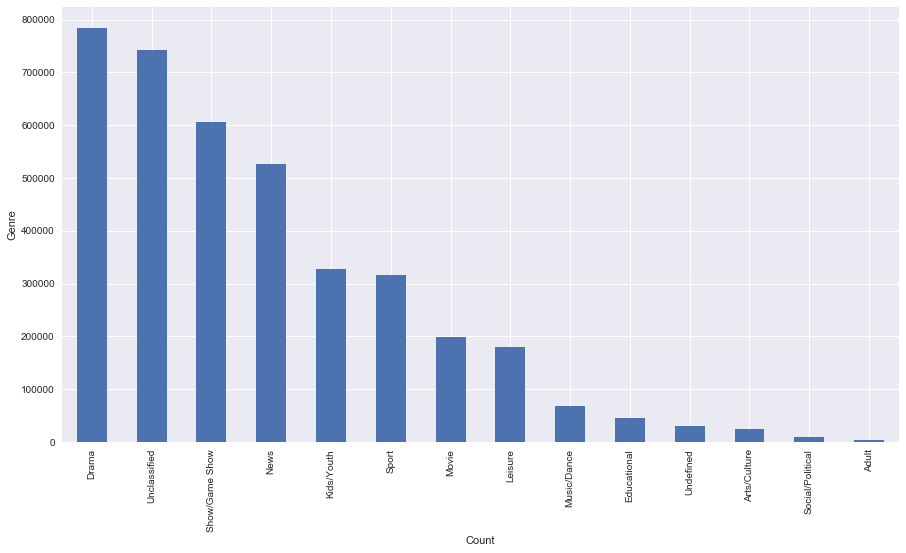

In [38]:
plt.xlabel('Count')
plt.ylabel('Genre')

plt.show();

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - 'Household_id' column  </h3>
 <p> household_id is definitely not behaving like a unique identifier in this dataset, hence a grouping will be required</p>
 </font>
</div>

In [39]:
#no null values
viewings.household_id.isnull().sum()

0

In [40]:
pd.Categorical(viewings.household_id).describe().sort_values(by='counts')#.iloc[:,1].sum()

,counts,freqs
categories,,
432226245,1,2.588567e-07
432219770,1,2.588567e-07
432216267,1,2.588567e-07
432216662,1,2.588567e-07
432222459,1,2.588567e-07
432228903,1,2.588567e-07
432227990,1,2.588567e-07
432224996,1,2.588567e-07
432218168,1,2.588567e-07


In [41]:
viewings.household_id.value_counts()

432221768    10831
432222470     8809
432217760     8458
432229035     8269
432227498     7744
432222758     7556
432228099     7552
432220886     6980
432220286     6949
432225494     6762
432223887     6573
432214748     6528
432216645     6381
432223659     6349
432218036     6314
432217964     6311
432228080     6217
432227127     6096
432214886     5951
432226310     5687
432228171     5646
432217742     5623
432223557     5612
432218679     5496
432216861     5329
432221847     5270
432224486     5221
432218654     5206
432219327     5184
432221846     5175
             ...  
432222722        8
432225081        8
432214736        8
432225993        8
432228860        7
432224163        7
432226250        7
432222867        7
432226443        7
432216717        6
432221415        5
432223256        5
432215126        5
432220172        5
432226101        5
432226623        3
432218211        3
432216867        3
432214539        2
432221229        2
432224996        1
432216662   

In [42]:
viewings.groupby("household_id").channel_name.describe()

,count,unique,top,freq
household_id,,,,
432214532,541,16,RTE One HD,304
432214538,149,55,Surf,58
432214539,2,1,National Geographic,2
432214544,84,11,RTE2 HD,26
432214551,102,7,RTE One HD,57
432214557,1717,54,BBC1 HD,342
432214562,1934,87,Surf,652
432214574,1347,34,Surf,308
432214575,608,32,FOX HD,71


In [43]:
grouper = viewings.groupby("household_id")

In [44]:
grouper.describe()


playback_speed                                              \
                      count         mean           std      min     25%   
household_id                                                              
432214532             539.0   998.144712     43.073049      0.0  1000.0   
432214538             149.0  1000.000000      0.000000   1000.0  1000.0   
432214539               2.0  1000.000000      0.000000   1000.0  1000.0   
432214544              84.0   976.190476    153.370995      0.0  1000.0   
432214551             102.0  1000.000000      0.000000   1000.0  1000.0   
432214557            1717.0  2929.528247   8988.482430 -30000.0  1000.0   
432214562            1934.0   996.380558     60.068352      0.0  1000.0   
432214574            1347.0  1684.484039   5109.419797 -30000.0  1000.0   
432214575             608.0  2555.921053   6599.148600 -30000.0  1000.0   
432214580              51.0   980.392157    140.028008      0.0  1000.0   
432214586             231.0  1000.000000      0.000000   1000.0  1000.0   
432214592            3278.0  3366.534472   6963.829538 -30000.0  1000.0   
432214604            5163.0  2379.140035   7116.531324 -30000.0  1000.0   
432214610            1128.0  3144.946809   8032.241552 -30000.0  1000.0   
432214611            3079.0  2423.514128   6153.223786 -30000.0  1000.0   
432214623             783.0  2061.302682   6052.103001 -30000.0  1000.0   
432214629             840.0  1029.761905   1950.598439 -12000.0  1000.0   
432214640            1116.0  4060.035842  10489.583883 -30000.0  1000.0   
432214646            1104.0  1000.000000      0.000000   1000.0  1000.0   
432214647            1109.0  1577.096483   4110.242802 -30000.0  1000.0   
432214664             772.0   886.010363    795.552579 -12000.0  1000.0   
432214665             539.0  1842.300557   5547.295055 -30000.0  1000.0   
432214670             366.0  2002.732240   9452.258883 -30000.0  1000.0   
432214671             215.0  1000.000000      0.000000   1000.0  1000.0   
432214682            1467.0  1557.600545   5970.132731 -30000.0  1000.0   
432214683             390.0  2557.692308   6971.471783 -30000.0  1000.0   
432214688             911.0  1435.784852   4176.069109 -30000.0  1000.0   
432214689             711.0  2580.872011   6223.886275  -6000.0  1000.0   
432214695             805.0  3314.285714   8280.340389 -30000.0  1000.0   
432214700            1516.0  2191.292876   8066.658146 -30000.0  1000.0   
...                     ...          ...           ...      ...     ...   
432229365             925.0  1854.054054   6657.783364 -30000.0  1000.0   
432229370            3235.0  2098.608964   9654.186766 -30000.0  1000.0   
432229376            1867.0  6581.146224  12415.555199 -30000.0  1000.0   
432229377            2258.0  1257.307352   4338.547809 -30000.0  1000.0   
432229383            1220.0  1873.770492   5929.761193 -30000.0  1000.0   
432229388             372.0   946.236559    405.237713  -6000.0  1000.0   
432229394             803.0  2452.054795   8510.877894 -30000.0  1000.0   
432229395            2283.0  3715.724923   9737.314620 -30000.0  1000.0   
432229406             247.0   995.951417     63.628476      0.0  1000.0   
432229412            2121.0  2639.321075   8026.403381 -30000.0  1000.0   
432229418            1160.0  2257.758621   7101.746080 -30000.0  1000.0   
432229419             721.0  1940.360610   6177.292142 -30000.0  1000.0   
432229425             732.0  4277.322404   9802.335322 -30000.0  1000.0   
432229430            2413.0  2811.852466   8086.457083 -30000.0  1000.0   
432229431            1698.0   989.988221    130.340653  -2000.0  1000.0   
432229436            1816.0  1268.447137   5098.499862 -30000.0  1000.0   
432229437             181.0   994.475138    166.574560      0.0  1000.0   
432229442             826.0  3935.835351   8128.483348 -30000.0  1000.0   
432229448            2825.0  4984.778761  11567.090073 -30000.0  1000.0   
432229460            1045.0   989.4736

In [45]:
#ax = viewings.groupby("household_id").size().plot(kind="bar", figsize=(20,4), logy=True)

<a id='section2'></a>

# SECTION 2. Data Cleaning

Modelling will be perfomed on two datasets:
- viewings_noNaN: this data will have all the rows with NaNs removed leaving a relatively small dataset to process.
- viewings_withNan: this data the NaNs in place to see how the models perform with NaNs. NB. After careful thought and time constraint, this idea was not tested, even thought the data are there.

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - inconsistent values  </h3>
 <p> It was noticed that there was an inconsistency in unclassified or unknown values. These were all standardised to 'unknown' in all variables. </p>
 </font>
</div>

In [46]:

viewings_withNaN = viewings

viewings_withNaN['gender'].replace(to_replace='To be specified', value='unknown', inplace=True)
viewings_withNaN['gender'].replace(to_replace='Please Specify', value='unknown', inplace=True)
viewings_withNaN['sub_genre'].replace(to_replace='Unclassified', value='unknown', inplace=True)
viewings_withNaN['sub_genre'].replace(to_replace='Undefined', value='unknown', inplace=True)
viewings_withNaN['genre'].replace(to_replace='Unclassified', value='unknown', inplace=True)
viewings_withNaN['genre'].replace(to_replace='Undefined', value='unknown', inplace=True)




In [47]:
# this abnormal value of date was assumed to be a erroneous entry; hence removed.
viewings_withNaN.loc[viewings['dob']=='1900-01-01', 'dob'] = pd.NaT

In [48]:
viewings_withNaN.dob.isnull().sum()

2568362

In [49]:
viewings_withNaN.gender.value_counts()

unknown    1501924
Male       1355064
Female     1006154
Name: gender, dtype: int64

In [50]:
viewings_withNaN.genre.value_counts()

Drama               784299
unknown             771228
Show/Game Show      606523
News                525893
Kids/Youth          327400
Sport               316665
Movie               198269
Leisure             180021
Music/Dance          69144
Educational          45682
Arts/Culture         24098
Social/Political     10103
Adult                 3817
Name: genre, dtype: int64

In [51]:
viewings_withNaN.sub_genre.value_counts()

unknown              1527755
Documentary           286112
For ages 6-14         272045
Variety Show          253966
Comedy                230728
Melodrama             224989
Crime                 153675
Football              125417
Talk Show              80712
Lifestyle              76478
Cooking                61685
Pre-School             53987
Rock/Pop               49242
Action                 39413
Drama                  38604
Thriller               37877
Discussion             37006
Sci-fi/Horror          34312
Nature                 32467
Equestrian             28118
Factual                26736
Team Sports            25455
Motoring               17555
Sci-Fi                 13969
Motor Sport            12020
Period                 10815
Further Education      10051
Shopping               10018
Martial Sports          8801
Travel                  7884
                      ...   
Fashion                 2292
Tennis/Squash           2112
Famous People           2031
Historical    

In [52]:
viewings_noNaN = viewings.dropna()

In [53]:
viewings_noNaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308702 entries, 3996 to 3862761
Data columns (total 16 columns):
household_id                308702 non-null int64
session_start               308702 non-null object
session_end                 308702 non-null object
channel_name                308702 non-null object
title                       308702 non-null object
original_broadcast_start    308702 non-null object
original_broadcast_end      308702 non-null object
session_type                308702 non-null object
session_sub_type            308702 non-null object
genre                       308702 non-null object
sub_genre                   308702 non-null object
playback_speed              308702 non-null float64
episode_title               308702 non-null object
series_title                308702 non-null object
gender                      308702 non-null object
dob                         308702 non-null object
dtypes: float64(1), int64(1), object(14)
memory usage: 40.0+ MB


In [54]:
viewings.count()

household_id                3863142
session_start               3863142
session_end                 3863142
channel_name                3863142
title                       3863137
original_broadcast_start    3850961
original_broadcast_end      3850961
session_type                3863142
session_sub_type            3863142
genre                       3863142
sub_genre                   3863142
playback_speed              3862360
episode_title               1058031
series_title                2091770
gender                      3863142
dob                         1294780
dtype: int64

In [55]:
viewings_withNaN.count()

household_id                3863142
session_start               3863142
session_end                 3863142
channel_name                3863142
title                       3863137
original_broadcast_start    3850961
original_broadcast_end      3850961
session_type                3863142
session_sub_type            3863142
genre                       3863142
sub_genre                   3863142
playback_speed              3862360
episode_title               1058031
series_title                2091770
gender                      3863142
dob                         1294780
dtype: int64

In [56]:
viewings_noNaN.count()

household_id                308702
session_start               308702
session_end                 308702
channel_name                308702
title                       308702
original_broadcast_start    308702
original_broadcast_end      308702
session_type                308702
session_sub_type            308702
genre                       308702
sub_genre                   308702
playback_speed              308702
episode_title               308702
series_title                308702
gender                      308702
dob                         308702
dtype: int64

In [57]:
viewings.shape

(3863142, 16)

In [58]:
viewings_withNaN.shape

(3863142, 16)

In [59]:
viewings_noNaN.shape

(308702, 16)

In [60]:
features_noNaN = viewings_noNaN.iloc[:, 0:14]

In [61]:
features_noNaN

,household_id,session_start,session_end,channel_name,title,original_broadcast_start,original_broadcast_end,session_type,session_sub_type,genre,sub_genre,playback_speed,episode_title,series_title
3996,432216770,2016-04-04 22:37:32,2016-04-04 22:44:16,E!,LA Clippers Dance Squad,2016-04-04 22:37:32,2016-04-04 23:00:00,LIVE,LIVE,Show/Game Show,unknown,1000.0,Adventures of the Floss Nest,LA Clippers Dance Squad
4005,432216770,2016-04-10 21:01:59,2016-04-10 21:07:23,Sky One,Hawaii Five-0,2016-04-10 21:01:59,2016-04-10 21:07:23,LIVE,LIVE,Drama,Crime,1000.0,Ka Pohaku Kihi Pa'a (The Solid Cornerstone),Hawaii Five-0 - Series 6
4006,432216770,2016-04-18 20:07:14,2016-04-18 20:10:09,E!,I Am Cait,2016-04-18 20:07:14,2016-04-18 20:10:09,LIVE,LIVE,Drama,Factual,1000.0,Guess Who's Coming to Dinner?,I Am Cait - Series 2
4007,432216770,2016-04-18 20:01:51,2016-04-18 20:02:32,E!,I Am Cait,2016-04-18 20:01:51,2016-04-18 20:02:32,LIVE,LIVE,Drama,Factual,1000.0,Guess Who's Coming to Dinner?,I Am Cait - Series 2
4046,432216770,2016-04-18 22:00:00,2016-04-18 22:02:40,E4,Empire,2016-04-18 22:00:00,2016-04-18 22:02:40,LIVE,LIVE,Drama,unknown,1000.0,A Rose By Any Other Name,Empire - Series 2
4071,432216770,2016-04-10 23:00:20,2016-04-10 23:02:57,TLC,My 600lb Life,2016-04-10 23:00:00,2016-04-10 23:02:37,TIMESHIFT,BUFFER,News,Documentary,1000.0,Seans Story,My 600lb Life - Series 4
4072,432216770,2016-04-12 13:03:07,2016-04-12 13:03:08,E4+1,Charmed,2016-04-12 13:03:07,2016-04-12 13:03:08,LIVE,LIVE,Drama,Sci-fi/Horror,1000.0,Hulkus Pocus,Charmed - Series 8
4077,432216770,2016-04-21 21:19:21,2016-04-21 21:21:13,Comedy +1,Friends,2016-04-21 21:19:21,2016-04-21 21:21:13,LIVE,LIVE,Drama,Comedy,1000.0,The One with the Girl from Poughkeepsie,Friends - Series 4
4078,432216770,2016-04-28 22:36:54,2016-04-28 22:39:56,E4+1,Angie Tribeca,2016-04-28 22:36:54,2016-04-28 22:39:56,LIVE,LIVE,Drama,Comedy,1000.0,Pilot,Angie Tribeca - Series 1
4079,432216770,2016-04-24 17:00:00,2016-04-24 17:00:00,Comedy,Friends,2016-04-24 17:00:00,2016-04-24 17:30:00,LIVE,LIVE,Drama,Comedy,1000.0,The One with All the Rugby,Friends - Series 4


<a id='section3'></a>

# SECTION 3 - Feature Generation and Clean Dataframe Construction

In [62]:
features= pd.DataFrame()

In [63]:
features['household_id']= viewings_noNaN.household_id

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - Removal of Timestamps and inferred feature generation  </h3>
 <p> Many ML predictors are not good with dealing with timestamps as features; moreover it was noted that if information was extracted from the timestamps then it might have a better influence in the prediction of age groups. Hence following inferred knowledge was extracted from the data: </p>
 
 <ul>Session Duration, Session Starting Hour, Day of the Week Session was watched </ul>
 <ul>Broadcast Duration, Broadcasting Starting Hour </ul>
 <ul>missed start; if the user missed that start of the programme</ul>
 
 </font>
</div>

In [64]:
#used to extract hour of the day, day of the week and year extracted from available timestamps in the data.
hour_of_day = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour
weekday = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()
year = lambda x: datetime.strptime(x, "%Y-%m-%d").year

In [65]:
features['session_start_hour'] = viewings_noNaN['session_start'].map(hour_of_day)

In [66]:
#features = features.drop('session_duration', 1)

In [67]:
features['session_duration'] = (pd.to_datetime(viewings_noNaN.session_end) - pd.to_datetime(viewings_noNaN.session_start)) / np.timedelta64(1, 'm')

In [68]:
features['session_weekday'] = viewings_noNaN['session_start'].map(weekday)

In [69]:
features['channel_name'] = viewings_noNaN['channel_name']


In [70]:
features['broadcast_hour'] = viewings_noNaN['original_broadcast_start'].map(hour_of_day)

In [71]:
features['missed_start'] = features['session_start_hour'] - features['broadcast_hour']

In [72]:
features.broadcast_hour.unique()

array([22, 21, 20, 23, 13, 17, 14, 18,  3, 15, 11, 19, 16,  9,  0,  2, 12,
        1, 10,  8,  4,  7,  5,  6], dtype=int64)

In [73]:
features['programme_duration'] = (pd.to_datetime(viewings_noNaN.original_broadcast_end) - pd.to_datetime(viewings_noNaN.original_broadcast_start)) / np.timedelta64(1, 'm')

In [74]:
features['session_type'] = viewings_noNaN['session_type']
                                               

In [75]:
features['session_sub_type'] = viewings_noNaN['session_sub_type']

In [76]:
features['genre'], features['sub_genre'] = viewings_noNaN['genre'], viewings_noNaN['sub_genre']

In [77]:
features['playback_speed'] = viewings_noNaN['playback_speed']

In [78]:
features['gender'] = viewings_noNaN['gender']

In [79]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308702 entries, 3996 to 3862761
Data columns (total 14 columns):
household_id          308702 non-null int64
session_start_hour    308702 non-null int64
session_duration      308702 non-null float64
session_weekday       308702 non-null int64
channel_name          308702 non-null object
broadcast_hour        308702 non-null int64
missed_start          308702 non-null int64
programme_duration    308702 non-null float64
session_type          308702 non-null object
session_sub_type      308702 non-null object
genre                 308702 non-null object
sub_genre             308702 non-null object
playback_speed        308702 non-null float64
gender                308702 non-null object
dtypes: float64(3), int64(5), object(6)
memory usage: 35.3+ MB


<a id='section4'></a>

# SECTION 4 - Calculating Target Variable - Age Group

A new dataframe with a the age group classification will be created from the 'dob' column. This will then be used for training and testing supervised classification. 

##### Note:
The function date.today() used to get the current date will give the date for the current timezone which might be different from the date of birth timezone. To rectify this, the timezone for each DoB will need to be recorded.

In [80]:
today = datetime.today()

In [81]:
#viewings_noNaN['age'] = (today - viewings_noNaN.dob).astype('timedelta64[Y]')

In [82]:
temptarget = (today - pd.to_datetime(viewings_noNaN['dob'])).astype('timedelta64[Y]')

In [83]:
temptarget

3996       33.0
4005       33.0
4006       33.0
4007       33.0
4046       33.0
4071       33.0
4072       33.0
4077       33.0
4078       33.0
4079       33.0
4080       33.0
4081       33.0
4082       33.0
4083       33.0
4085       33.0
4086       33.0
4087       33.0
4088       33.0
4089       33.0
4090       33.0
4091       33.0
4095       33.0
4128       33.0
4129       33.0
4130       33.0
4156       33.0
4157       33.0
4158       33.0
4159       33.0
4160       33.0
           ... 
3862663    31.0
3862664    31.0
3862665    31.0
3862666    31.0
3862667    31.0
3862668    31.0
3862669    31.0
3862670    31.0
3862671    31.0
3862672    31.0
3862673    31.0
3862674    31.0
3862676    31.0
3862680    31.0
3862681    31.0
3862682    31.0
3862683    31.0
3862684    31.0
3862685    31.0
3862687    31.0
3862692    31.0
3862693    31.0
3862744    31.0
3862745    31.0
3862746    31.0
3862747    31.0
3862748    31.0
3862749    31.0
3862751    31.0
3862761    31.0
Name: dob, Length: 30870

In [84]:
# viewings_noNaN['age_group']= viewings_noNaN.age.astype('timedelta64[Y]')

In [85]:
criteria = [temptarget < 25,
            (temptarget >= 25) & (temptarget < 35),
            (temptarget >= 35) & (temptarget < 45),
            (temptarget >= 45) & (temptarget < 55),
            (temptarget >= 55) & (temptarget < 65),
            temptarget >= 65]

outputs = ['<25', '25-35','35-45','45-55','55-65','66']

target_noNaN = pd.DataFrame(np.select(criteria, outputs), columns=['age_group'])

In [86]:
target_noNaN.age_group.value_counts()


35-45    114873
25-35     66180
45-55     65208
55-65     40450
66        20169
<25        1822
Name: age_group, dtype: int64

### Data with NaNs

In [87]:
temptarget = (today - pd.to_datetime(viewings_withNaN.dob)).astype('timedelta64[Y]')

In [88]:
criteria = [temptarget < 25,
            (temptarget >= 25) & (temptarget < 35),
            (temptarget >= 35) & (temptarget < 45),
            (temptarget >= 45) & (temptarget < 55),
            (temptarget >= 55) & (temptarget < 65),
            temptarget >= 65]
            

outputs = ['<25', '25-35','35-45','45-55','55-65','66']

target_withNaN = pd.DataFrame(np.select(criteria, outputs), columns=['age_group'])

In [89]:
target_withNaN

,age_group
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [90]:
target_withNaN['age_group'].replace(to_replace='0', value=np.nan, inplace=True)

In [91]:
target_withNaN['age_group'].isnull().sum()

2568362

In [92]:
pd.Categorical(target_withNaN.age_group).describe().sort_index()

,counts,freqs
categories,,
NaN,2568362,0.664838
25-35,257894,0.066758
35-45,422335,0.109324
45-55,293862,0.076068
55-65,188622,0.048826
66,123880,0.032067
<25,8187,0.002119


<a id='section5'></a>

# SECTION 5 - Enconding

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - One Hot and Label Encoding  </h3>
 <p> it was essential that textual data was converted to numerical form, ensuring they stay ordinal. Two techniques were tested here, i.e. One-Hot and Label Encoding. Both feature sets were tested with models </p>
 
 
 
 </font>
</div>

In [93]:
from sklearn import preprocessing

In [94]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308702 entries, 3996 to 3862761
Data columns (total 14 columns):
household_id          308702 non-null int64
session_start_hour    308702 non-null int64
session_duration      308702 non-null float64
session_weekday       308702 non-null int64
channel_name          308702 non-null object
broadcast_hour        308702 non-null int64
missed_start          308702 non-null int64
programme_duration    308702 non-null float64
session_type          308702 non-null object
session_sub_type      308702 non-null object
genre                 308702 non-null object
sub_genre             308702 non-null object
playback_speed        308702 non-null float64
gender                308702 non-null object
dtypes: float64(3), int64(5), object(6)
memory usage: 35.3+ MB


In [95]:
features.loc[:, features.dtypes == np.object]

,channel_name,session_type,session_sub_type,genre,sub_genre,gender
3996,E!,LIVE,LIVE,Show/Game Show,unknown,Female
4005,Sky One,LIVE,LIVE,Drama,Crime,Female
4006,E!,LIVE,LIVE,Drama,Factual,Female
4007,E!,LIVE,LIVE,Drama,Factual,Female
4046,E4,LIVE,LIVE,Drama,unknown,Female
4071,TLC,TIMESHIFT,BUFFER,News,Documentary,Female
4072,E4+1,LIVE,LIVE,Drama,Sci-fi/Horror,Female
4077,Comedy +1,LIVE,LIVE,Drama,Comedy,Female
4078,E4+1,LIVE,LIVE,Drama,Comedy,Female
4079,Comedy,LIVE,LIVE,Drama,Comedy,Female


In [96]:
X_cat = features.loc[:, features.dtypes == np.object]

In [97]:
X_cat

,channel_name,session_type,session_sub_type,genre,sub_genre,gender
3996,E!,LIVE,LIVE,Show/Game Show,unknown,Female
4005,Sky One,LIVE,LIVE,Drama,Crime,Female
4006,E!,LIVE,LIVE,Drama,Factual,Female
4007,E!,LIVE,LIVE,Drama,Factual,Female
4046,E4,LIVE,LIVE,Drama,unknown,Female
4071,TLC,TIMESHIFT,BUFFER,News,Documentary,Female
4072,E4+1,LIVE,LIVE,Drama,Sci-fi/Horror,Female
4077,Comedy +1,LIVE,LIVE,Drama,Comedy,Female
4078,E4+1,LIVE,LIVE,Drama,Comedy,Female
4079,Comedy,LIVE,LIVE,Drama,Comedy,Female


In [98]:
X_cat.columns

Index(['channel_name', 'session_type', 'session_sub_type', 'genre',
       'sub_genre', 'gender'],
      dtype='object')

In [99]:
X_num = features.drop(X_cat.columns, 1)

In [100]:
X_num.columns

Index(['household_id', 'session_start_hour', 'session_duration',
       'session_weekday', 'broadcast_hour', 'missed_start',
       'programme_duration', 'playback_speed'],
      dtype='object')

In [101]:
X = features

### one-hot encoding

In [102]:
onehot = pd.get_dummies(X_cat, columns=['channel_name','session_type','session_sub_type','genre','sub_genre','gender'])

In [103]:
onehot= onehot.join(X_num)

In [104]:
onehot.columns

Index(['channel_name_3e', 'channel_name_4Music', 'channel_name_Alibi',
       'channel_name_Animal Planet', 'channel_name_BBC 1',
       'channel_name_BBC 2', 'channel_name_BBC FOUR',
       'channel_name_BBC News 24', 'channel_name_BBC THREE',
       'channel_name_BBC TWO HD',
       ...
       'gender_Male', 'gender_unknown', 'household_id', 'session_start_hour',
       'session_duration', 'session_weekday', 'broadcast_hour', 'missed_start',
       'programme_duration', 'playback_speed'],
      dtype='object', length=195)

In [105]:
onehot

,channel_name_3e,channel_name_4Music,channel_name_Alibi,channel_name_Animal Planet,channel_name_BBC 1,channel_name_BBC 2,channel_name_BBC FOUR,channel_name_BBC News 24,channel_name_BBC THREE,channel_name_BBC TWO HD,...,gender_Male,gender_unknown,household_id,session_start_hour,session_duration,session_weekday,broadcast_hour,missed_start,programme_duration,playback_speed
3996,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,22,6.733333,0,22,0,22.466667,1000.0
4005,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,21,5.400000,6,21,0,5.400000,1000.0
4006,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,20,2.916667,0,20,0,2.916667,1000.0
4007,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,20,0.683333,0,20,0,0.683333,1000.0
4046,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,22,2.666667,0,22,0,2.666667,1000.0
4071,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,23,2.616667,6,23,0,2.616667,1000.0
4072,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,13,0.016667,1,13,0,0.016667,1000.0
4077,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,21,1.866667,3,21,0,1.866667,1000.0
4078,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,22,3.033333,3,22,0,3.033333,1000.0
4079,0,0,0,0,0,0,0,0,0,0,...,0,0,432216770,17,0.000000,6,17,0,30.000000,1000.0


### label encoding

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308702 entries, 3996 to 3862761
Data columns (total 14 columns):
household_id          308702 non-null int64
session_start_hour    308702 non-null int64
session_duration      308702 non-null float64
session_weekday       308702 non-null int64
channel_name          308702 non-null object
broadcast_hour        308702 non-null int64
missed_start          308702 non-null int64
programme_duration    308702 non-null float64
session_type          308702 non-null object
session_sub_type      308702 non-null object
genre                 308702 non-null object
sub_genre             308702 non-null object
playback_speed        308702 non-null float64
gender                308702 non-null object
dtypes: float64(3), int64(5), object(6)
memory usage: 45.3+ MB


In [107]:
Y = target_noNaN

In [108]:
le = preprocessing.LabelEncoder()

In [109]:
X2 = X_cat.apply(le.fit_transform)
Y2 = Y.apply(le.fit_transform)

In [110]:
X2

,channel_name,session_type,session_sub_type,genre,sub_genre,gender
3996,41,0,1,9,41,0
4005,92,0,1,2,5,0
4006,41,0,1,2,12,0
4007,41,0,1,2,12,0
4046,42,0,1,2,41,0
4071,109,2,0,8,7,0
4072,43,0,1,2,34,0
4077,23,0,1,2,3,0
4078,43,0,1,2,3,0
4079,22,0,1,2,3,0


In [111]:
Y2 == 1

,age_group
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


In [112]:
X_coded = X_num.join(X2)

In [113]:
X_coded

,household_id,session_start_hour,session_duration,session_weekday,broadcast_hour,missed_start,programme_duration,playback_speed,channel_name,session_type,session_sub_type,genre,sub_genre,gender
3996,432216770,22,6.733333,0,22,0,22.466667,1000.0,41,0,1,9,41,0
4005,432216770,21,5.400000,6,21,0,5.400000,1000.0,92,0,1,2,5,0
4006,432216770,20,2.916667,0,20,0,2.916667,1000.0,41,0,1,2,12,0
4007,432216770,20,0.683333,0,20,0,0.683333,1000.0,41,0,1,2,12,0
4046,432216770,22,2.666667,0,22,0,2.666667,1000.0,42,0,1,2,41,0
4071,432216770,23,2.616667,6,23,0,2.616667,1000.0,109,2,0,8,7,0
4072,432216770,13,0.016667,1,13,0,0.016667,1000.0,43,0,1,2,34,0
4077,432216770,21,1.866667,3,21,0,1.866667,1000.0,23,0,1,2,3,0
4078,432216770,22,3.033333,3,22,0,3.033333,1000.0,43,0,1,2,3,0
4079,432216770,17,0.000000,6,17,0,30.000000,1000.0,22,0,1,2,3,0


In [114]:
X2.shape

(308702, 6)

In [115]:
# features.apply(preprocessing.LabelEncoder().fit_transform)

# # Encoding the variable
# fit = features.apply(lambda x: d[x.name].fit_transform(x))

# # Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# features.apply(lambda x: d[x.name].transform(x))

<a id='section6'></a>

# SECTION 6 - Feature Selection

In [116]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [117]:
names = target_noNaN.columns.values

In [118]:
#X = features_noNaN
X = onehot

In [119]:
negcols = X.columns[(X < 0).any()].tolist() # negative values are not acceptable in SelectKBest

In [120]:
X = X.drop(negcols, 1)

In [121]:
X.shape

(308702, 192)

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - Feature Selection Methods  </h3>
 <p> The methods used to test feature importance are K Highest Score, Variance and Random Forest Regressor</p>
 
 </font>
</div>

In [122]:
test = SelectKBest(score_func=chi2, k=100)

In [123]:
X.shape

(308702, 192)

In [124]:
fit = test.fit(X, Y)

In [125]:
Xnew = fit.transform(X)


In [126]:
Xnew.shape

(308702, 100)

In [127]:
Xnew

array([[  0.        ,   0.        ,   0.        , ...,  22.        ,
          6.73333333,  22.        ],
       [  0.        ,   0.        ,   0.        , ...,  21.        ,
          5.4       ,  21.        ],
       [  0.        ,   0.        ,   0.        , ...,  20.        ,
          2.91666667,  20.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,  18.        ,
          0.        ,  18.        ],
       [  0.        ,   0.        ,   0.        , ...,  21.        ,
          0.        ,  21.        ],
       [  0.        ,   0.        ,   0.        , ...,   1.        ,
          0.        ,   1.        ]])

In [128]:
mask = test.get_support() #list of booleans
features_hotone_KBest = [] # The list of your K best features

for bool, Xnew in zip(mask, X.columns):
    if bool:
        features_hotone_KBest.append(Xnew)

In [129]:
features_hotone_KBest

['channel_name_Alibi',
 'channel_name_Animal Planet',
 'channel_name_BBC 2',
 'channel_name_BBC FOUR',
 'channel_name_BBC TWO HD',
 'channel_name_BBC1 HD',
 'channel_name_Boomerang',
 'channel_name_CBBC',
 'channel_name_CN+1',
 'channel_name_CNBC Europe',
 'channel_name_Cartoon Network',
 'channel_name_Cartoonito',
 'channel_name_Cbeebies',
 'channel_name_Comedy',
 'channel_name_Comedy +1',
 'channel_name_Comedy Extra',
 'channel_name_DMAX',
 'channel_name_Discovery',
 'channel_name_Discovery HD',
 'channel_name_Discovery History',
 'channel_name_Discovery Quest',
 'channel_name_Discovery Shed',
 'channel_name_Discovery Turbo',
 'channel_name_Disney Channel',
 'channel_name_Disney Channel HD',
 'channel_name_Disney Junior',
 'channel_name_E!',
 'channel_name_E4',
 'channel_name_Food Network',
 'channel_name_G.O.L.D.',
 'channel_name_G.O.L.D. +1',
 'channel_name_H2',
 'channel_name_History Channel',
 'channel_name_History HD',
 'channel_name_ID',
 'channel_name_ITV2',
 'channel_name_ITV

In [130]:
scores = fit.scores_

In [131]:
scores

array([  2.21386516e+01,   5.48474964e+01,   6.31957738e+02,
         3.90296967e+02,   1.39171709e+01,   5.12387539e+02,
         1.15704114e+03,   6.95243090e+00,   1.68733297e+00,
         3.23535174e+02,   1.46873586e+01,   1.59255616e+03,
         6.32931083e+01,   6.26640434e+02,   4.33362004e+02,
         6.02417583e+02,   9.15416295e+02,   1.86993442e+03,
         2.23922868e+03,   1.42028046e+03,   7.22934642e+01,
         8.00163321e+01,   1.27459797e+03,   1.17548068e+03,
         5.42857043e+02,   8.51088726e+01,   3.03550814e+01,
         3.07334306e+01,   2.21878281e+02,   1.32448678e+02,
         2.48401059e+01,   3.27226968e+02,   1.50744139e+03,
         9.33795379e+02,   3.08155787e+02,   1.04976873e+02,
         6.88630578e+02,   6.20488980e+02,   2.21717873e+02,
         7.75269018e+02,   2.21803669e+03,   8.55726814e+02,
         1.59340418e+03,   1.60350836e+02,   1.87180864e+02,
         2.62466115e+01,   9.69392778e+01,   1.63888173e+02,
         5.65109953e+02,

In [132]:
plt.plot(scores);

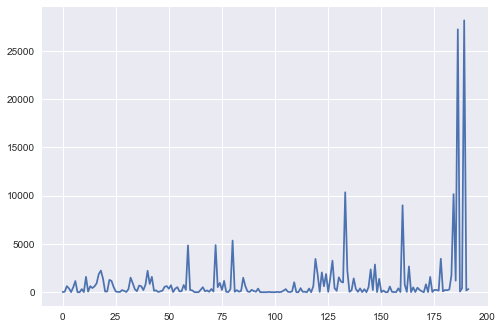

In [133]:
plt.show()

In [134]:
X = X_coded

In [135]:
X.shape

(308702, 14)

In [136]:
negcols = X.columns[(X < 0).any()].tolist() # negative values are not acceptable in SelectKBest

In [137]:
X = X.drop(negcols, 1)

In [138]:
X.shape

(308702, 11)

In [139]:
test = SelectKBest(score_func=chi2, k=10)

In [140]:
X

,household_id,session_start_hour,session_duration,session_weekday,broadcast_hour,channel_name,session_type,session_sub_type,genre,sub_genre,gender
3996,432216770,22,6.733333,0,22,41,0,1,9,41,0
4005,432216770,21,5.400000,6,21,92,0,1,2,5,0
4006,432216770,20,2.916667,0,20,41,0,1,2,12,0
4007,432216770,20,0.683333,0,20,41,0,1,2,12,0
4046,432216770,22,2.666667,0,22,42,0,1,2,41,0
4071,432216770,23,2.616667,6,23,109,2,0,8,7,0
4072,432216770,13,0.016667,1,13,43,0,1,2,34,0
4077,432216770,21,1.866667,3,21,23,0,1,2,3,0
4078,432216770,22,3.033333,3,22,43,0,1,2,3,0
4079,432216770,17,0.000000,6,17,22,0,1,2,3,0


In [141]:
fit = test.fit(X, Y)

In [142]:
Xnew = fit.transform(X)


In [143]:
Xnew.shape

(308702, 10)

In [144]:
Xnew

array([[ 22.        ,   6.73333333,   0.        , ...,   9.        ,
         41.        ,   0.        ],
       [ 21.        ,   5.4       ,   6.        , ...,   2.        ,
          5.        ,   0.        ],
       [ 20.        ,   2.91666667,   0.        , ...,   2.        ,
         12.        ,   0.        ],
       ..., 
       [ 18.        ,   0.        ,   1.        , ...,   2.        ,
          3.        ,   1.        ],
       [ 21.        ,   0.        ,   5.        , ...,   2.        ,
          3.        ,   1.        ],
       [  1.        ,   0.        ,   0.        , ...,   9.        ,
         40.        ,   1.        ]])

In [145]:
mask = test.get_support() #list of booleans
features_coded_Kbest = [] # The list of your K best features

for bool, Xnew in zip(mask, X.columns):
    if bool:
        features_coded_Kbest.append(Xnew)

In [146]:
features_coded_Kbest

['session_start_hour',
 'session_duration',
 'session_weekday',
 'broadcast_hour',
 'channel_name',
 'session_type',
 'session_sub_type',
 'genre',
 'sub_genre',
 'gender']

In [147]:
scores = fit.scores_

In [148]:
scores

array([    70.56498366,    412.80918472,  28127.76174936,    179.45399584,
          328.4789545 ,  22506.22272897,   4112.47146069,   3709.44177541,
         1162.83727912,   6795.13129421,  18888.53548369])

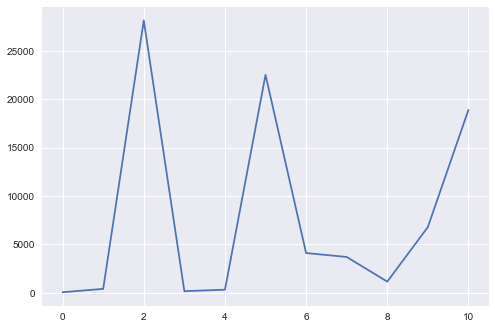

In [149]:
plt.plot(scores)
plt.show();

## Variance

In [150]:
from sklearn.feature_selection import VarianceThreshold

### Label Encoded

In [151]:
X = X_coded

In [152]:
X.shape

(308702, 14)

In [153]:
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))

In [154]:
fit = sel.fit_transform(X)

In [155]:
fit.shape

(308702, 14)

In [156]:
mask = test.get_support() #list of booleans
features_coded_Var = [] # The list of your K best features

for bool, Xnew in zip(mask, X.columns):
    if bool:
        features_coded_Var.append(Xnew)

### Onehot

In [157]:
X = onehot

In [158]:
X.shape

(308702, 195)

In [159]:
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))

In [160]:
Xnew = sel.fit_transform(X)

In [161]:
Xnew.shape

(308702, 23)

In [162]:
Xnew

array([[    1.        ,     0.        ,     0.        , ...,
            0.        ,    22.46666667,  1000.        ],
       [    1.        ,     0.        ,     0.        , ...,
            0.        ,     5.4       ,  1000.        ],
       [    1.        ,     0.        ,     0.        , ...,
            0.        ,     2.91666667,  1000.        ],
       ..., 
       [    1.        ,     0.        ,     0.        , ...,
            0.        ,    30.        ,  1000.        ],
       [    1.        ,     0.        ,     0.        , ...,
            0.        ,    30.        ,  1000.        ],
       [    0.        ,     1.        ,     1.        , ...,
            0.        ,    30.        ,  1000.        ]])

In [163]:
mask = sel.get_support() #list of booleans
features_onehot_Var = [] # The list of your K best features

for bool, Xnew in zip(mask, X.columns):
    if bool:
        features_onehot_Var.append(Xnew)

In [164]:
features_onehot_Var

['session_type_LIVE',
 'session_type_TIMESHIFT',
 'session_sub_type_BUFFER',
 'session_sub_type_LIVE',
 'session_sub_type_SERIES LINK BOOKING',
 'genre_Drama',
 'genre_Kids/Youth',
 'genre_Show/Game Show',
 'sub_genre_Comedy',
 'sub_genre_Crime',
 'sub_genre_For ages 6-14',
 'sub_genre_unknown',
 'gender_Female',
 'gender_Male',
 'gender_unknown',
 'household_id',
 'session_start_hour',
 'session_duration',
 'session_weekday',
 'broadcast_hour',
 'missed_start',
 'programme_duration',
 'playback_speed']

## Random Forrest Regressor Feature Selection

In [165]:
from sklearn.ensemble import RandomForestRegressor

In [166]:
rf = RandomForestRegressor()

### with One Hot Features

In [167]:
X = onehot

In [168]:
rf.fit(X,Y2.iloc[:,0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [169]:
a = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X.columns), reverse=True)

In [170]:
a

[(0.62549999999999994, 'household_id'),
 (0.093299999999999994, 'gender_unknown'),
 (0.027300000000000001, 'genre_Kids/Youth'),
 (0.014999999999999999, 'channel_name_ITV3'),
 (0.013100000000000001, 'broadcast_hour'),
 (0.011900000000000001, 'programme_duration'),
 (0.0115, 'gender_Male'),
 (0.0114, 'session_weekday'),
 (0.011299999999999999, 'session_start_hour'),
 (0.010200000000000001, 'session_duration'),
 (0.0097999999999999997, 'session_sub_type_SERIES LINK BOOKING'),
 (0.0080999999999999996, 'sub_genre_Comedy'),
 (0.0061999999999999998, 'gender_Female'),
 (0.0057999999999999996, 'missed_start'),
 (0.0055999999999999999, 'channel_name_RTE2 HD'),
 (0.0050000000000000001, 'channel_name_Alibi'),
 (0.0047999999999999996, 'channel_name_TLC'),
 (0.0047999999999999996, 'channel_name_Nick Junior'),
 (0.0044999999999999997, 'session_type_TIMESHIFT'),
 (0.0043, 'channel_name_Sky One'),
 (0.0043, 'channel_name_E4'),
 (0.0043, 'channel_name_BBC1 HD'),
 (0.0038999999999999998, 'genre_Drama'),


### with Coded Features

In [171]:
X = X_coded

In [172]:
rf.fit(X,Y2.iloc[:,0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [173]:
a = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X.columns), reverse=True)

In [174]:
a

[(0.66779999999999995, 'household_id'),
 (0.10349999999999999, 'gender'),
 (0.0683, 'channel_name'),
 (0.0309, 'sub_genre'),
 (0.0184, 'genre'),
 (0.0167, 'programme_duration'),
 (0.016299999999999999, 'broadcast_hour'),
 (0.016, 'session_weekday'),
 (0.015599999999999999, 'session_start_hour'),
 (0.015100000000000001, 'session_sub_type'),
 (0.013299999999999999, 'session_duration'),
 (0.0083999999999999995, 'missed_start'),
 (0.0080999999999999996, 'session_type'),
 (0.0015, 'playback_speed')]

## commonly selected features in both Var and SelectKBest

In [175]:
featurelist_coded = set(features_coded_Kbest) & set(features_coded_Var)

In [176]:
featurelist_coded = list(featurelist_coded)

In [177]:
featurelist_coded

['broadcast_hour',
 'session_start_hour',
 'session_duration',
 'session_weekday',
 'channel_name',
 'session_sub_type',
 'session_type']

In [178]:
features_coded = X_coded[featurelist_coded]

In [179]:
features_coded.shape

(308702, 7)

In [180]:
featurelist_onehot = set(features_onehot_Var) & set(features_hotone_KBest)

In [181]:
featurelist_onehot = list(featurelist_onehot)

In [182]:
featurelist_onehot

['session_type_TIMESHIFT',
 'gender_unknown',
 'session_start_hour',
 'broadcast_hour',
 'sub_genre_Comedy',
 'session_duration',
 'genre_Show/Game Show',
 'genre_Kids/Youth',
 'sub_genre_unknown',
 'sub_genre_For ages 6-14',
 'gender_Female',
 'sub_genre_Crime',
 'session_sub_type_LIVE',
 'session_sub_type_BUFFER',
 'genre_Drama',
 'session_type_LIVE',
 'session_sub_type_SERIES LINK BOOKING',
 'gender_Male']

In [183]:
features_onehot = onehot[featurelist_onehot]

In [184]:
features_onehot.shape

(308702, 18)

<div style="background-color:rgba(210,255,210, 1); text-align:left; padding:10px 0;">
 
 <font color='black'>
 <h3> Observation - Modelling Results  </h3>
 <p> After carefully chosing the features using the above mentioned methods it was noted that none of the techniques used were provided appropriate combination of features to produce an acceptable prediction. This could be due to less thought been given to the application or appropriatness of the techniques used.
 
 However, it was noted that if extracted features were not filtered throught he selection process and all were used in the classification, the results were far better and acceptable. </p>
 
 <br>
 
 <p>Nonetheless, there is a very likely chance that the better results are due to overfitting, which is neither been tested or regulaised in this exercise. But is something that should be given serious considertion. Moreover, Cross Validation would play an important role in trusting the accuracies generated. <br> </p>
 
<p> Also, a pipeline would also have been benefitial for a better organised workflow.</p>

<br><br>

<p> Both the test performed on full dataset and selected features are presented below. The models used are:</p>

<ul>K-Nearest Neighbour </ul>
 <ul>Logistic Regression </ul>
 <ul>Random Forest Classifier</ul>
 
 <br><br>
 <p> It was noted that Random Forest worked the best with accuracy of 0.985 (beware of overfitting) while logistic regression performed the least favourable. Also full cleaned data generated with all NaNs removed preformed better</p>
 
 <p> With such classifiers, it is important that the feature importance and feature sensitivity is quantifiable. Explainable AI and explaining the decisions made by black box classifier is essential to understand the outputs. </p>
 
 <br>
 <p> Currently the workflow is comuputationally intensive which needs to be looked at. <br> The features need to be disjunctive and most probably ranked. Chi Square perhaps is not the best way to do it considering the size of data sample. <br> Also better graphics can be used to explain the over-fitting</p>
 
 <br><br><br>
 
 <p> Personally I think TensorFlow can handle the onehot much better and faster than sklearn and any other python library. Also this application is gagging for a neural net to be implmented, most likely a convolution NN </p>
 
 </font>
</div>

<a id='section7'></a>

# SECTION 7 - Splitting data into Training and Validation with full data

### One Hot

In [185]:
from sklearn.model_selection import train_test_split

In [186]:
TrainX_onehot, TestX_onehot, TrainY_onehot, TestY_onehot = train_test_split(onehot, Y2, train_size = 0.7, test_size=0.3)

In [187]:
TrainX_onehot.shape

(216091, 195)

In [188]:
TestX_onehot.shape

(92611, 195)

In [189]:
TrainY_onehot.shape

(216091, 1)

In [190]:
TestY_onehot.shape

(92611, 1)

### Encoded

In [191]:
TrainX_coded, TestX_coded, TrainY_coded, TestY_coded = train_test_split(X_coded, Y2, train_size = 0.7, test_size=0.3)

In [192]:
TrainX_coded.shape

(216091, 14)

In [193]:
TestX_coded.shape

(92611, 14)

In [194]:
TrainY_coded.shape

(216091, 1)

In [195]:
TestY_coded.shape

(92611, 1)

<a id='section8'></a>

# SECTION 8 - Creating a Model with full data

In [196]:
from sklearn import neighbors, linear_model, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix




In [197]:
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()



In [198]:
TrainY_coded.iloc[:,0]

302231    1
4500      0
151233    0
156760    1
127659    2
14268     0
116721    4
161710    3
91362     2
117684    2
135754    1
239443    4
65384     2
89741     3
257852    2
299989    2
94588     4
79269     3
5497      1
85890     2
250528    2
110778    0
130620    1
184577    2
125868    0
43337     1
148652    1
244867    3
85946     2
81883     1
         ..
158448    1
262778    1
239478    4
77432     4
157059    1
265536    1
240884    3
74197     1
203639    0
81301     1
260640    2
44741     3
295727    0
268953    0
83436     0
39142     0
99520     1
148726    1
222737    3
25501     2
9661      1
67294     1
99760     2
177984    1
164341    1
87011     2
261663    3
220052    3
150600    0
280950    0
Name: age_group, Length: 216091, dtype: int64

In [199]:
TrainY_onehot.iloc[:,0]

291175    2
124900    1
53598     1
111273    4
300592    0
149206    1
50909     1
189582    2
43226     1
60972     0
272435    0
289532    1
122495    1
262469    2
161580    3
304016    3
184486    2
175956    1
115712    2
267162    1
280588    0
112338    0
140108    3
144535    1
127134    2
212523    1
7294      3
133664    1
293863    1
124573    1
         ..
203281    0
109504    0
157200    1
259603    1
271520    2
301778    0
47245     0
198528    0
196354    1
272675    0
153055    1
249508    2
29262     0
214255    4
46383     1
307810    2
150335    4
244593    3
42164     1
18498     0
126853    2
211287    1
223988    0
155963    1
211725    1
187250    1
96537     4
129514    3
282207    3
124347    1
Name: age_group, Length: 216091, dtype: int64

In [200]:
knn.fit(TrainX_coded, TrainY_coded.iloc[:,0]).score(TestX_coded, TestY_coded.iloc[:,0])


0.91205148416494797

In [201]:
knn.fit(TrainX_onehot, TrainY_onehot.iloc[:,0]).score(TestX_onehot, TestY_onehot.iloc[:,0])


0.94865620714601939

In [202]:
logistic.fit(TrainX_coded, TrainY_coded.iloc[:,0]).score(TestX_coded, TestY_coded.iloc[:,0])

0.37428599194480139

In [203]:
logistic.fit(TrainX_onehot, TrainY_onehot.iloc[:,0]).score(TestX_onehot, TestY_onehot.iloc[:,0])

0.37130578441005929

In [204]:
rf = RandomForestRegressor()

In [205]:
trained = rf.fit(TrainX_coded, TrainY_coded.iloc[:,0])

In [206]:
prediction = trained.predict(TestX_coded)

In [207]:
for i in range(0, 5):
        print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(TestY_coded.iloc[:,0])[i], prediction[i]))

Actual outcome :: 3 and Predicted outcome :: 3.0
Actual outcome :: 1 and Predicted outcome :: 0.9
Actual outcome :: 2 and Predicted outcome :: 2.0
Actual outcome :: 0 and Predicted outcome :: 0.1
Actual outcome :: 1 and Predicted outcome :: 1.0


In [208]:
coded_test_accuracy = accuracy_score(TestY_coded.iloc[:,0], prediction.round())

In [209]:
coded_test_accuracy

0.93861420349634495

In [210]:
coded_train_accuracy = accuracy_score(TrainY_coded.iloc[:,0], (trained.predict(TrainX_coded)).round())

In [211]:
coded_train_accuracy

0.98211864445997288

In [212]:
cm = confusion_matrix(TestY_coded.iloc[:,0], prediction.round())

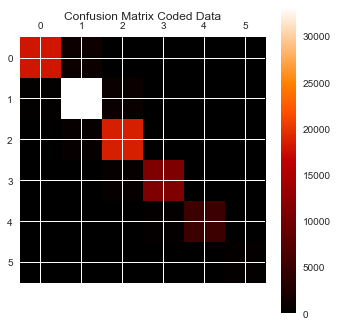

In [213]:
plt.matshow(cm, cmap='gist_heat');
plt.title('Confusion Matrix Coded Data');
plt.colorbar();
plt.show();

In [214]:
rf = RandomForestRegressor()

In [215]:
trained = rf.fit(TrainX_onehot, TrainY_onehot.iloc[:,0])

In [216]:
prediction = trained.predict(TestX_onehot)

In [217]:
for i in range(0, 5):
        print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(TestY_onehot.iloc[:,0])[i], prediction[i]))

Actual outcome :: 3 and Predicted outcome :: 3.0
Actual outcome :: 0 and Predicted outcome :: 0.1
Actual outcome :: 3 and Predicted outcome :: 3.0
Actual outcome :: 1 and Predicted outcome :: 1.0
Actual outcome :: 0 and Predicted outcome :: 0.0


In [218]:
accuracy_score(TestY_onehot, prediction.round())

0.94770599604798567

In [219]:
onehot_test_accuracy = accuracy_score(TestY_onehot.iloc[:,0], prediction.round())

In [220]:
onehot_test_accuracy

0.94770599604798567

In [221]:
onehot_train_accuracy = accuracy_score(TrainY_onehot.iloc[:,0], (trained.predict(TrainX_onehot)).round())

In [222]:
onehot_train_accuracy

0.98521919006344549

In [223]:
cm = confusion_matrix(TestY_onehot.iloc[:,0], prediction.round())

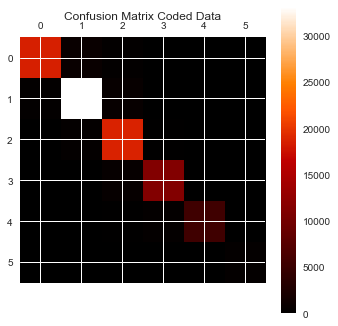

In [224]:
plt.matshow(cm, cmap='gist_heat');
plt.title('Confusion Matrix Coded Data');
plt.colorbar();
plt.show();

<a id='section9'></a>

# SECTION 9 - Splitting data into Training and Validation with feature selected data

### One Hot

In [225]:
from sklearn.model_selection import train_test_split

In [226]:
TrainX_onehot, TestX_onehot, TrainY_onehot, TestY_onehot = train_test_split(features_onehot, Y, train_size = 0.7, test_size=0.3)

In [227]:
TrainX_onehot.shape

(216091, 18)

In [228]:
!pip install lime

In [229]:
import lime
import lime.lime_tabular

In [230]:
feature_names = TrainX_coded.columns.values
class_names = TrainY_coded.columns[0]

In [231]:
train=TrainX_coded.values

test = TestX_coded.values

In [232]:
test[2]

array([  4.32226898e+08,   8.00000000e+00,   6.66666667e-02,
         2.00000000e+00,   2.10000000e+01,  -1.30000000e+01,
         6.66666667e-02,   1.00000000e+03,   1.70000000e+01,
         2.00000000e+00,   3.00000000e+00,   4.00000000e+00,
         1.80000000e+01,   1.00000000e+00])

In [233]:
TestX_onehot.shape

(92611, 18)

In [234]:
TrainY_onehot.shape

(216091, 1)

In [235]:
TestY_onehot.shape

(92611, 1)

### Encoded

In [236]:
TrainX_coded, TestX_coded, TrainY_coded, TestY_coded = train_test_split(features_coded, Y2, train_size = 0.7, test_size=0.3)

In [237]:
TrainX_coded.shape

(216091, 7)

In [238]:
TestX_coded.shape

(92611, 7)

In [239]:
TrainY_coded.shape

(216091, 1)

In [240]:
TestY_coded.shape

(92611, 1)

<a id='section10'></a>

# SECTION 10 - Creating a Model with feature selected data

In [241]:
from sklearn import neighbors, linear_model, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix




In [242]:
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()



In [243]:
TrainY_coded.iloc[:,0]

91149     2
263888    0
228511    3
128242    2
306926    0
128070    2
94450     4
30753     0
180029    0
184956    4
120026    2
38532     0
52895     0
105880    0
65967     0
69385     3
126948    2
241791    2
220567    3
293864    1
12584     2
202186    2
102968    2
244865    3
145498    0
75879     2
141435    1
301881    0
255704    3
136055    0
         ..
259610    1
148594    1
176672    2
205645    1
58726     1
263365    1
240114    3
288154    2
78938     1
101641    1
123490    0
103491    1
76315     1
274806    1
289594    1
250563    0
250785    1
234519    2
40713     5
285549    0
184725    1
106891    2
52190     3
46977     3
113555    1
259855    2
216275    2
276738    1
287983    2
53501     1
Name: age_group, Length: 216091, dtype: int64

In [244]:
TrainY_onehot.iloc[:,0]

88479     25-35
182368    25-35
96721     45-55
137268    55-65
237394    35-45
51370     25-35
177059    35-45
22270     25-35
108528    35-45
95002        66
143271    45-55
113999    25-35
151637    25-35
61596     45-55
29896     45-55
13189     45-55
155355    45-55
283191    55-65
217727    55-65
31969     55-65
37214     35-45
265867    35-45
306120       66
180091    25-35
231512    25-35
133327    35-45
75797     45-55
105305    25-35
195567    35-45
67726     35-45
          ...  
13250     45-55
131666    35-45
112489    35-45
98748     35-45
214103       66
151959    25-35
87885     45-55
24261     35-45
294053       66
303789       66
294719    35-45
166021    35-45
15390     35-45
160755    35-45
234348    35-45
248539    35-45
204581    35-45
251201    35-45
103112    35-45
264795    35-45
11156     25-35
191532    55-65
207577    25-35
35400     35-45
184800    35-45
209691    55-65
261015    25-35
130443    35-45
75373     35-45
166794    35-45
Name: age_group, Length:

In [245]:
knn.fit(TrainX_coded, TrainY_coded.iloc[:,0]).score(TestX_coded, TestY_coded.iloc[:,0])


0.51584584984505077

In [246]:
knn.fit(TrainX_onehot, TrainY_onehot.iloc[:,0]).score(TestX_onehot, TestY_onehot.iloc[:,0])


0.46396216432173282

In [247]:
logistic.fit(TrainX_coded, TrainY_coded.iloc[:,0]).score(TestX_coded, TestY_coded.iloc[:,0])

0.37261232466985561

In [248]:
logistic.fit(TrainX_onehot, TrainY_onehot.iloc[:,0]).score(TestX_onehot, TestY_onehot.iloc[:,0])

0.39129261102892743

In [249]:
rf = RandomForestRegressor()

In [250]:
trained = rf.fit(TrainX_coded, TrainY_coded.iloc[:,0])

In [251]:
prediction = trained.predict(TestX_coded)

In [252]:
for i in range(0, 5):
        print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(TestY_coded.iloc[:,0])[i], prediction[i]))

Actual outcome :: 1 and Predicted outcome :: 0.4916706232835265
Actual outcome :: 1 and Predicted outcome :: 1.0
Actual outcome :: 3 and Predicted outcome :: 1.1617327117327119
Actual outcome :: 1 and Predicted outcome :: 0.9447584510432808
Actual outcome :: 1 and Predicted outcome :: 1.6


In [253]:
coded_test_accuracy = accuracy_score(TestY_coded.iloc[:,0], prediction.round())

In [254]:
coded_test_accuracy

0.50222975672436321

In [255]:
coded_train_accuracy = accuracy_score(TrainY_coded.iloc[:,0], (trained.predict(TrainX_coded)).round())

In [256]:
coded_train_accuracy

0.73625000578459998

In [257]:
cm = confusion_matrix(TestY_coded.iloc[:,0], prediction.round())

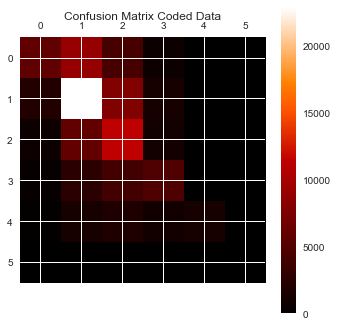

In [258]:
plt.matshow(cm, cmap='gist_heat');
plt.title('Confusion Matrix Coded Data');
plt.colorbar();
plt.show();

In [259]:
rf = RandomForestRegressor()

In [260]:
trained = rf.fit(TrainX_onehot, TrainY_coded.iloc[:,0])

In [261]:
prediction = trained.predict(TestX_onehot)

In [262]:
for i in range(0, 5):
        print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(TestY_coded.iloc[:,0])[i], prediction[i]))

Actual outcome :: 1 and Predicted outcome :: 1.2
Actual outcome :: 1 and Predicted outcome :: 2.5966666666666667
Actual outcome :: 3 and Predicted outcome :: 2.0
Actual outcome :: 1 and Predicted outcome :: 1.3
Actual outcome :: 1 and Predicted outcome :: 1.0


In [263]:
accuracy_score(TestY_coded, prediction.round())

0.28479338307544461

In [264]:
onehot_test_accuracy = accuracy_score(TestY_coded.iloc[:,0], prediction.round())

In [265]:
onehot_test_accuracy

0.28479338307544461

In [266]:
onehot_train_accuracy = accuracy_score(TrainY_coded.iloc[:,0], (trained.predict(TrainX_onehot)).round())

In [267]:
onehot_train_accuracy

0.52979069003336554

In [268]:
cm = confusion_matrix(TestY_coded.iloc[:,0], prediction.round())

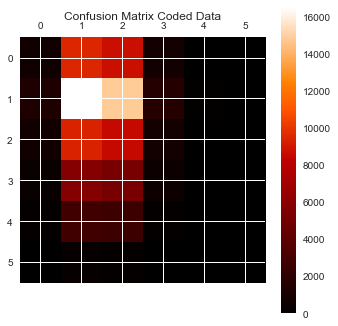

In [269]:
plt.matshow(cm, cmap='gist_heat');
plt.title('Confusion Matrix Coded Data');
plt.colorbar();
plt.show();